In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Set device to GPU P100 on KAGGLE NOTEBOOK 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Define paths based on your screenshot structure
base_path = '/kaggle/input/hc18-grandchallenge/hc18/hc18'
train_img_dir = os.path.join(base_path, '/kaggle/input/hc18-grandchallenge/hc18/hc18/training_set')
test_img_dir = os.path.join(base_path, '/kaggle/input/hc18-grandchallenge/hc18/hc18/test_set')
train_csv_path = os.path.join(base_path, '/kaggle/input/hc18-grandchallenge/training_set_pixel_size_and_HC.csv')

# Load the CSV file
df = pd.read_csv(train_csv_path)

# Verify the data loaded correctly
print(f"Total training samples: {len(df)}")
df.head()

Total training samples: 999


,filename,pixel size(mm),head circumference (mm)
0,000_HC.png,0.069136,44.30
1,001_HC.png,0.089659,56.81
2,002_HC.png,0.062033,68.75
3,003_HC.png,0.091291,69.00
4,004_HC.png,0.061240,59.81


# EDA

Missing values:
 filename                   0
pixel size(mm)             0
head circumference (mm)    0
dtype: int64

Statistics for Head Circumference (mm):
count    999.000000
mean     174.383093
std       65.282061
min       44.300000
25%      153.600000
50%      174.060000
75%      189.825000
max      346.400000
Name: head circumference (mm), dtype: float64


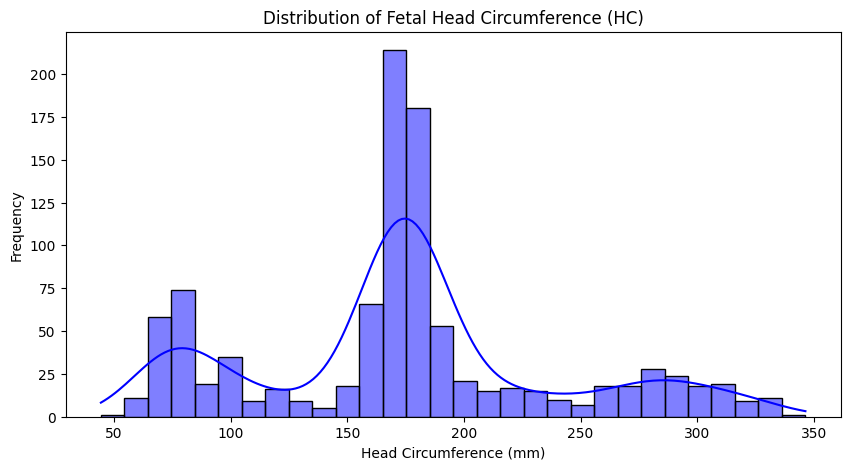

In [5]:
# 1. Check for missing values
print("Missing values:\n", df.isnull().sum())

# 2. Statistical summary of Head Circumference (HC)
print("\nStatistics for Head Circumference (mm):")
print(df['head circumference (mm)'].describe())

# 3. Visualize the distribution
plt.figure(figsize=(10, 5))
sns.histplot(df['head circumference (mm)'], kde=True, bins=30, color='blue')
plt.title('Distribution of Fetal Head Circumference (HC)')
plt.xlabel('Head Circumference (mm)')
plt.ylabel('Frequency')
plt.show()

## : Data Preprocessing (Transforms)


ResNet50 requires input images of size 224x224.  ultrasound is grayscale (1 channel) and ResNet expects RGB (3 channels), duplicate the channels in the transformation step.

In [11]:
# Define image transformations
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),       # Resize to standard ResNet input
    transforms.Grayscale(num_output_channels=3), # Convert 1 channel -> 3 channels for ResNet
    transforms.ToTensor(),               # Convert to Tensor [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # ImageNet normalization standards
                         std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

## Custom Dataset Class

In [13]:
class HC18Dataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.df = dataframe
        self.img_dir = img_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # Get file name and label
        row = self.df.iloc[idx]
        filename = row['filename']
        label = row['head circumference (mm)']
        
        # Load Image
        img_path = os.path.join(self.img_dir, filename)
        image = Image.open(img_path) # Load as PIL
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
            
        # Return image and label (converted to float32 tensor)
        return image, torch.tensor(label, dtype=torch.float32)

## Exact Data Splitting
shuffle the dataframe to ensure randomness, then slice it into the exact counts you requested: 600 Train, 200 Val, 199 Test.

In [14]:
# 1. Shuffle the dataframe to ensure random distribution before splitting
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

# 2. Slice the dataframe into exact counts
# Training: First 600
train_df = df_shuffled.iloc[:600]

# Validation: Next 200 (Index 600 to 800)
val_df = df_shuffled.iloc[600:800]

# Test: Next 199 (Index 800 to 999)
test_df = df_shuffled.iloc[800:999]

print(f"Training Set Size:   {len(train_df)}")
print(f"Validation Set Size: {len(val_df)}")
print(f"Test Set Size:       {len(test_df)}")
print(f"Total:               {len(train_df) + len(val_df) + len(test_df)}")

Training Set Size:   600
Validation Set Size: 200
Test Set Size:       199
Total:               999


## Defining Specific Augmentation Transforms

 define three separate transform pipelines. 
 
 Note: PyTorch RandomAffine uses a fraction for translation. Since we need a 5-pixel offset on a 224x224 image, the fraction is calculated as $5/224 \approx 0.022$.

In [17]:
# 1. Base Transform (For Original Train, Validation, and Test)
base_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 2. Augmentation 1: Horizontal Flipping (Deterministic for dataset expansion)
aug_flip_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=1.0), # p=1.0 ensures it ALWAYS flips
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 3. Augmentation 2: Rotation (10 deg) & Translation (5px)
# 5 pixels / 224 pixels = 0.0223
aug_rot_trans_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomAffine(degrees=10, translate=(0.0223, 0.0223)), 
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

## Expanding the Dataset and Creating Loaders
 create three dataset objects for the training data and combine them using ConcatDataset. 
 
 ==?> expands the training list from 600 to 1800 items.

In [20]:
from torch.utils.data import ConcatDataset

# --- create Training Datasets ---
# 1. Original Data (600)
train_ds_original = HC18Dataset(train_df, train_img_dir, transform=base_transform)

# 2. Flipped Data (600)
train_ds_flipped = HC18Dataset(train_df, train_img_dir, transform=aug_flip_transform)

# 3. Rotated/Translated Data (600)
train_ds_rotated = HC18Dataset(train_df, train_img_dir, transform=aug_rot_trans_transform)

# Combine them into one Training Dataset (600 + 600 + 600 = 1800)
full_train_dataset = ConcatDataset([train_ds_original, train_ds_flipped, train_ds_rotated])

# --- Create Validation and Test Datasets (No Augmentation) ---
val_dataset = HC18Dataset(val_df, train_img_dir, transform=base_transform)
test_dataset = HC18Dataset(test_df, train_img_dir, transform=base_transform)

# --- Check Sizes ---
print(f"Final Augmented Training Size: {len(full_train_dataset)}")
print(f"Validation Size: {len(val_dataset)}")
print(f"Test Size: {len(test_dataset)}")

# --- Create DataLoaders ---
BATCH_SIZE = 32

train_loader = DataLoader(full_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Final Augmented Training Size: 1800
Validation Size: 200
Test Size: 199


# experimental setup

build  ResNet50 

In [21]:
import torch.nn as nn
from torchvision import models

def get_resnet50_regression_model(device):
    # 1. Load Pre-trained ResNet50
    # Weights='DEFAULT' loads the best available ImageNet weights
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    
    # 2. Modify Input Layer (Optional but recommended for Grayscale)
    # ResNet expects 3 channels. We already handled this in transforms, 
    # but strictly speaking, we can just use the standard RGB input layer.
    
    # 3. Modify the Output Layer (The Classifier)
    # ResNet50's final layer is named 'fc' and has 2048 input features.
    num_ftrs = model.fc.in_features
    
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, 1) # Output: 1 single value (HC)
    )
    
    return model.to(device)

model = get_resnet50_regression_model(device)
print("ResNet50 Regression Model initialized.")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 208MB/s]


ResNet50 Regression Model initialized.


In [24]:

criterion = nn.HuberLoss(delta=0.5)


optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


def calculate_mae(outputs, targets):
    return torch.mean(torch.abs(outputs - targets))

def calculate_pmae(outputs, targets):
    # Percentage MAE: (|pred - true| / true) * 100
    return torch.mean(torch.abs((outputs - targets) / targets)) * 100

In [25]:
import time

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    best_val_mae = float('inf')
    history = {'train_loss': [], 'val_loss': [], 'val_mae': [], 'val_pmae': []}
    
    print(f"Starting training on {device} for {num_epochs} epochs...")
    
    for epoch in range(num_epochs):
        start_time = time.time()
        
        # --- Training Phase ---
        model.train()
        running_loss = 0.0
        
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            targets = targets.unsqueeze(1) # Ensure shape match [Batch, 1]
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            
        epoch_loss = running_loss / len(train_loader.dataset)
        
        # --- Validation Phase ---
        model.eval()
        val_loss = 0.0
        val_mae_accum = 0.0
        val_pmae_accum = 0.0
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                targets = targets.unsqueeze(1)
                
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                val_loss += loss.item() * inputs.size(0)
                val_mae_accum += calculate_mae(outputs, targets).item() * inputs.size(0)
                val_pmae_accum += calculate_pmae(outputs, targets).item() * inputs.size(0)
        
        # Calculate Averages
        avg_val_loss = val_loss / len(val_loader.dataset)
        avg_val_mae = val_mae_accum / len(val_loader.dataset)
        avg_val_pmae = val_pmae_accum / len(val_loader.dataset)
        
        # Store history
        history['train_loss'].append(epoch_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_mae'].append(avg_val_mae)
        history['val_pmae'].append(avg_val_pmae)
        
        # Save best model
        if avg_val_mae < best_val_mae:
            best_val_mae = avg_val_mae
            torch.save(model.state_dict(), 'best_resnet50_hc18.pth')
            saved_msg = "-> Model Saved"
        else:
            saved_msg = ""
            
        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {epoch_loss:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | "
              f"Val MAE: {avg_val_mae:.2f} mm | "
              f"Val pMAE: {avg_val_pmae:.2f}% {saved_msg}")
              
    return history

# Run Training
history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25)

Starting training on cuda for 25 epochs...
Epoch 1/25 | Train Loss: 72.4999 | Val Loss: 27.8541 | Val MAE: 55.96 mm | Val pMAE: 30.19% -> Model Saved
Epoch 2/25 | Train Loss: 13.4782 | Val Loss: 13.2339 | Val MAE: 26.72 mm | Val pMAE: 13.80% -> Model Saved
Epoch 3/25 | Train Loss: 8.6149 | Val Loss: 11.2656 | Val MAE: 22.78 mm | Val pMAE: 11.65% -> Model Saved
Epoch 4/25 | Train Loss: 7.4672 | Val Loss: 7.4930 | Val MAE: 15.23 mm | Val pMAE: 8.96% -> Model Saved
Epoch 5/25 | Train Loss: 7.1926 | Val Loss: 9.4260 | Val MAE: 19.10 mm | Val pMAE: 10.43% 
Epoch 6/25 | Train Loss: 6.7363 | Val Loss: 10.3009 | Val MAE: 20.85 mm | Val pMAE: 11.05% 
Epoch 7/25 | Train Loss: 6.1873 | Val Loss: 5.2454 | Val MAE: 10.74 mm | Val pMAE: 6.13% -> Model Saved
Epoch 8/25 | Train Loss: 5.7823 | Val Loss: 6.7180 | Val MAE: 13.68 mm | Val pMAE: 7.75% 
Epoch 9/25 | Train Loss: 5.4471 | Val Loss: 11.1388 | Val MAE: 22.53 mm | Val pMAE: 12.05% 
Epoch 10/25 | Train Loss: 5.7286 | Val Loss: 5.7660 | Val MAE: 1

## Visualize Training Performance

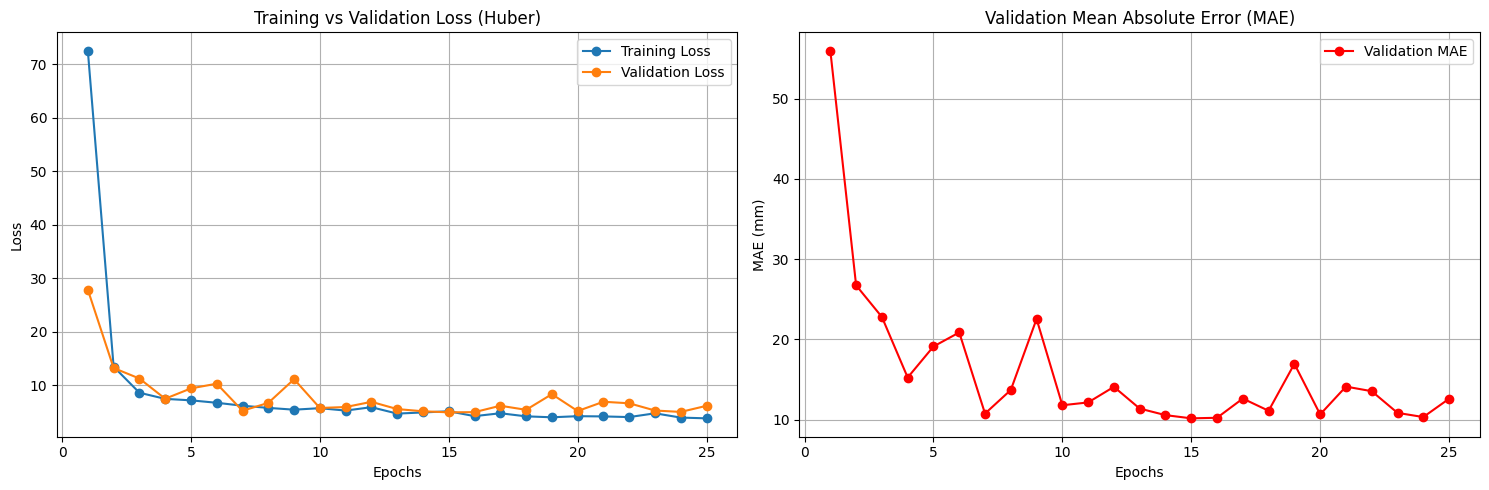

In [26]:
def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
    
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Loss Curves
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Training Loss', marker='o')
    plt.plot(epochs, history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Training vs Validation Loss (Huber)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot 2: MAE Curves
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['val_mae'], label='Validation MAE', color='red', marker='o')
    plt.title('Validation Mean Absolute Error (MAE)')
    plt.xlabel('Epochs')
    plt.ylabel('MAE (mm)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

# Evaluate on Test Set
 load the "best" version of the model (saved during training) and run it on the 199 unseen test images to get the final score.

what is HL
https://www.geeksforgeeks.org/machine-learning/huber-loss-function-in-machine-learning/


In [27]:
def evaluate_on_test(model, test_loader, criterion):
    # Load the best weights saved during training
    model.load_state_dict(torch.load('best_resnet50_hc18.pth'))
    model.eval()
    
    test_loss = 0.0
    test_mae_accum = 0.0
    test_pmae_accum = 0.0
    
    all_preds = []
    all_targets = []
    
    print("Evaluating on Test Set...")
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            targets = targets.unsqueeze(1)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Accumulate metrics
            test_loss += loss.item() * inputs.size(0)
            test_mae_accum += calculate_mae(outputs, targets).item() * inputs.size(0)
            test_pmae_accum += calculate_pmae(outputs, targets).item() * inputs.size(0)
            
            all_preds.extend(outputs.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            
    # Calculate Averages
    avg_test_loss = test_loss / len(test_loader.dataset)
    avg_test_mae = test_mae_accum / len(test_loader.dataset)
    avg_test_pmae = test_pmae_accum / len(test_loader.dataset)
    
    print("-" * 30)
    print(f"Final Test Results (on {len(test_loader.dataset)} images):")
    print(f"Test Loss (Huber): {avg_test_loss:.4f}")
    print(f"Test MAE:          {avg_test_mae:.2f} mm")
    print(f"Test pMAE:         {avg_test_pmae:.2f} %")
    print("-" * 30)
    
    return all_preds, all_targets

# Run Evaluation
predictions, actuals = evaluate_on_test(model, test_loader, criterion)

Evaluating on Test Set...
------------------------------
Final Test Results (on 199 images):
Test Loss (Huber): 4.4144
Test MAE:          9.07 mm
Test pMAE:         6.30 %
------------------------------


# Update Dataset to Support Pixel metrics

In [38]:
class HC18DatasetExtended(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.df = dataframe
        self.img_dir = img_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        filename = row['filename']
        label_mm = row['head circumference (mm)']
        pixel_size = row['pixel size(mm)'] # Crucial for pixel-level metrics
        
        img_path = os.path.join(self.img_dir, filename)
        image = Image.open(img_path)
        
        if self.transform:
            image = self.transform(image)
            
        return image, torch.tensor(label_mm, dtype=torch.float32), torch.tensor(pixel_size, dtype=torch.float32)

# --- Re-create Data Splits ---
# We use the same split logic as before
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)
train_df = df_shuffled.iloc[:600]
val_df = df_shuffled.iloc[600:800]
test_df = df_shuffled.iloc[800:999]

# --- Define Transforms (Reuse from previous steps) ---
# (Assuming base_transform, aug_flip_transform, aug_rot_trans_transform are defined in Cell 8)

Setup Data Scenarios (With and Without DA)

In [39]:
# 1. Dataset WITHOUT Data Augmentation (Standard)
train_ds_no_da = HC18DatasetExtended(train_df, train_img_dir, transform=base_transform)
test_ds = HC18DatasetExtended(test_df, train_img_dir, transform=base_transform) # Test set is always same

loader_no_da = DataLoader(train_ds_no_da, batch_size=32, shuffle=True, num_workers=2)
test_loader_eval = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2)

# 2. Dataset WITH Data Augmentation (Expansion strategy 600->1800)
ds_orig = HC18DatasetExtended(train_df, train_img_dir, transform=base_transform)
ds_flip = HC18DatasetExtended(train_df, train_img_dir, transform=aug_flip_transform)
ds_rot = HC18DatasetExtended(train_df, train_img_dir, transform=aug_rot_trans_transform)

train_ds_with_da = ConcatDataset([ds_orig, ds_flip, ds_rot])
loader_with_da = DataLoader(train_ds_with_da, batch_size=32, shuffle=True, num_workers=2)

# Dictionary to hold scenarios
data_scenarios = {
    'Without DA': loader_no_da,
    'With DA': loader_with_da
}

print("Data Scenarios Prepared.")


Data Scenarios Prepared.


Comparison Engine


This function runs a full training session and evaluates the model, returning the mean and standard deviation of the error in pixels.

In [41]:
def run_experiment(name, train_loader, loss_fn, num_epochs=10):
    print(f"\n>>> Running Experiment: {name}")
    
    # 1. Initialize fresh ResNet50
    model = get_resnet50_regression_model(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    
    # 2. Train
    model.train()
    for epoch in range(num_epochs):
        for images, targets, _ in train_loader: # Ignore pixel_size during training
            images, targets = images.to(device), targets.to(device)
            targets = targets.unsqueeze(1)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            
    # 3. Evaluate on Test Set (Calculate MAE in Pixels)
    model.eval()
    pixel_errors = []
    
    with torch.no_grad():
        for images, targets_mm, pixel_sizes in test_loader_eval:
            images = images.to(device)
            targets_mm = targets_mm.to(device).unsqueeze(1)
            pixel_sizes = pixel_sizes.to(device).unsqueeze(1)
            
            preds_mm = model(images)
            
            # Convert error from mm to pixels: Error_px = |Pred_mm - Target_mm| / PixelSize_mm
            abs_error_mm = torch.abs(preds_mm - targets_mm)
            abs_error_px = abs_error_mm / pixel_sizes
            
            pixel_errors.extend(abs_error_px.cpu().numpy().flatten())
            
    # 4. Calculate Stats
    mean_mae_px = np.mean(pixel_errors)
    std_mae_px = np.std(pixel_errors)
    
    print(f"Result: {mean_mae_px:.2f} ± {std_mae_px:.2f} pixels")
    return mean_mae_px, std_mae_px

Run All 6 Experiments


We loop through the 2 Data Scenarios and 3 Loss Functions.

In [42]:
import pandas as pd

# Define Loss Functions
loss_functions = {
    'MAE (L1)': nn.L1Loss(),
    'MSE (L2)': nn.MSELoss(),
    'Huber': nn.HuberLoss(delta=0.5)
}

results = []

# Loop 1: Data Scenarios (No DA vs With DA)
for data_name, loader in data_scenarios.items():
    
    # Loop 2: Loss Functions
    for loss_name, loss_fn in loss_functions.items():
        exp_id = f"{data_name} + {loss_name}"
        
        # Run! (Using 10 epochs for speed, increase to 20+ for better accuracy)
        mean_px, std_px = run_experiment(exp_id, loader, loss_fn, num_epochs=10)
        
        results.append({
            'Data Strategy': data_name,
            'Loss Function': loss_name,
            'MAE (Pixels)': mean_px,
            'Std Dev (Pixels)': std_px
        })

# Create Summary Table
results_df = pd.DataFrame(results)


>>> Running Experiment: Without DA + MAE (L1)
Result: 95.75 ± 88.10 pixels

>>> Running Experiment: Without DA + MSE (L2)
Result: 123.62 ± 101.27 pixels

>>> Running Experiment: Without DA + Huber
Result: 101.59 ± 88.73 pixels

>>> Running Experiment: With DA + MAE (L1)
Result: 80.17 ± 81.59 pixels

>>> Running Experiment: With DA + MSE (L2)
Result: 110.68 ± 79.38 pixels

>>> Running Experiment: With DA + Huber
Result: 78.11 ± 91.20 pixels
